In [2]:
import os, sys, time
import numpy as np
from pandas import read_csv
from scipy.stats import zscore
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

from kshape.core import kshape, zscore
from dtaidistance import dtw

from tqdm import tqdm
from preprocessingandrecords import *
from experimentsetup import *
from plotty import *

import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
main_dir = "opsd-time_series-2020-10-06/"
dataset = None
for (root,dirs,files) in os.walk(main_dir):
    for f in files:
        if "60min_singleindex.csv" in f:
            dataset = read_csv(main_dir+f)
            break
        
fullcountrylist = []
for k in dataset.keys():
    if "load_actual_entsoe_transparency" in k:
        if "50hertz" not in k:
            fullcountrylist.append(k)


l = ['Austria', 'Cyprus', 'Germany', 'Denmark', 'Estonia', 'Spain', 'Great Britain', 'United Kingdom', 'Greece', "Croatia",  'Hungary', 'Italy','Lithuania','Latvia', 'Norway', 'Portugal', 'Sweden', 'Slovakia']

lab = ['AT_load_actual_entsoe_transparency','CY_load_actual_entsoe_transparency',  'DE_load_actual_entsoe_transparency', 'DK_load_actual_entsoe_transparency', 'EE_load_actual_entsoe_transparency', 'ES_load_actual_entsoe_transparency', 'GB_GBN_load_actual_entsoe_transparency', 'GB_UKM_load_actual_entsoe_transparency', 'GR_load_actual_entsoe_transparency','HR_load_actual_entsoe_transparency', 'HU_load_actual_entsoe_transparency', 'IT_load_actual_entsoe_transparency', 'LT_load_actual_entsoe_transparency', 'LV_load_actual_entsoe_transparency',  'NO_load_actual_entsoe_transparency', 'PT_load_actual_entsoe_transparency', 'SE_load_actual_entsoe_transparency', 'SK_load_actual_entsoe_transparency']

label_colors = {i:'k' for i in l}

print(len(l),len(lab))

18 18


In [3]:
## YEH + PRECIS
e_PRECIS = Experiment("PHASEINV", [4,24*2], algyield=True, multivariate=False, downsamplefactor=1)
a = np.array(dataset['utc_timestamp'])
print("Timestamps: {}, {}".format(a[0],a[-1]))
use_dicts = []
for lk_idx in tqdm(range(len(lab))):
    lk = lab[lk_idx]
    ts = dataset[lk]
    dat = zscore(ts.to_numpy(),nan_policy='omit')
    d, idxs = e_PRECIS.make_exemplar(dat)
    use_dicts.append(d)
YEHPRECISdistmat = e_PRECIS.distmat_from_dicts(use_dicts)

  0%|          | 0/18 [00:00<?, ?it/s]

Timestamps: 2014-12-31T23:00:00Z, 2020-09-30T23:00:00Z


Make Distmat: 100%|██████████| 18/18 [00:05<00:00,  3.39it/s]


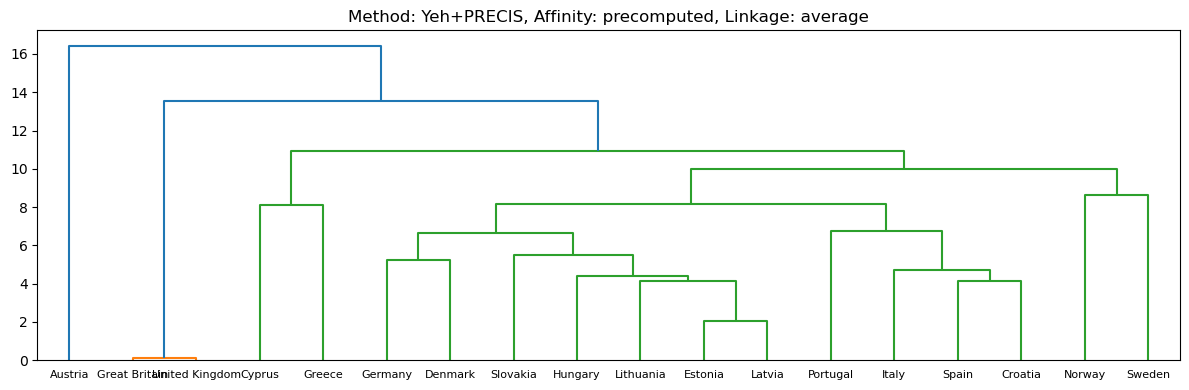

In [7]:
plotty_ac(None, "Yeh+PRECIS", 'precomputed', 'average', YEHPRECISdistmat, l, label_colors)

<Figure size 1000x200 with 0 Axes>

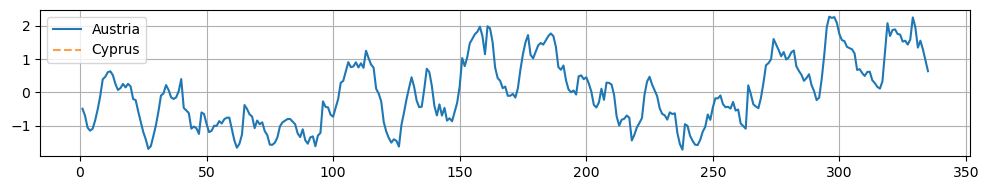

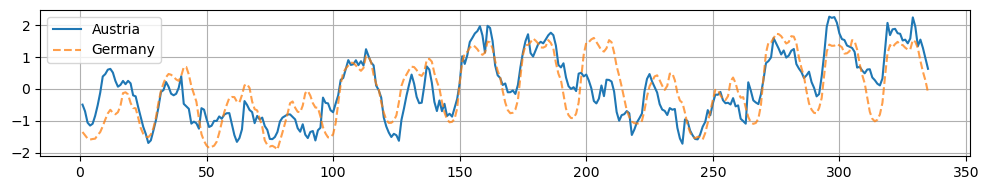

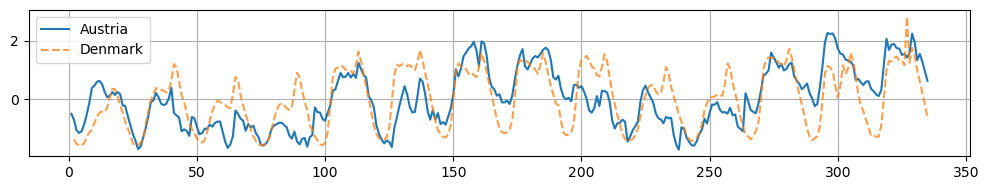

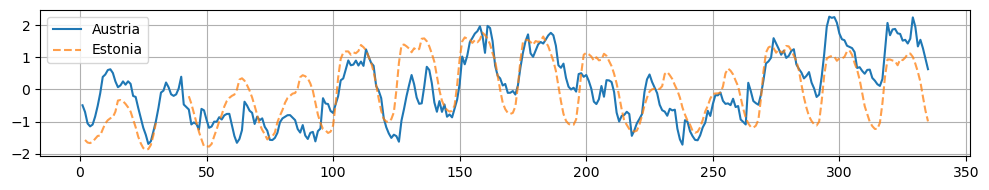

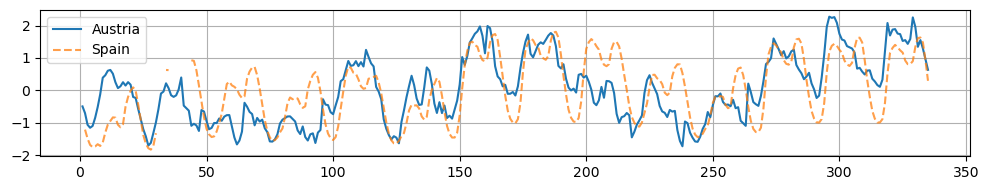

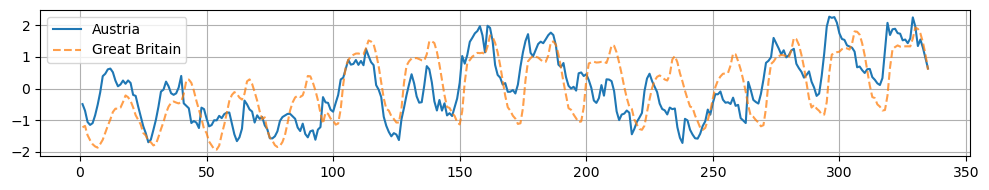

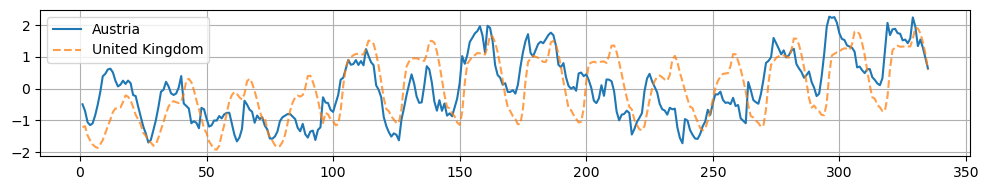

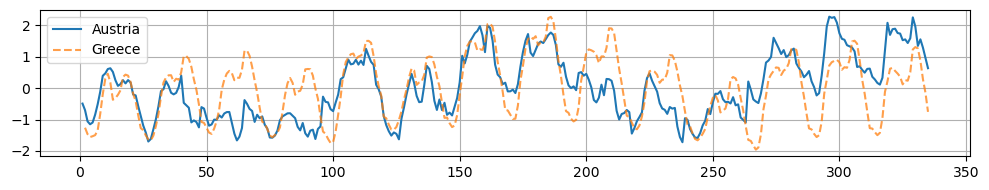

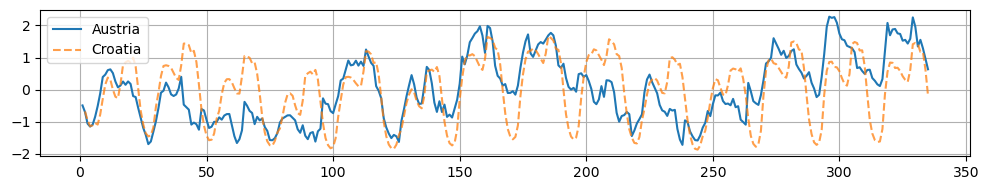

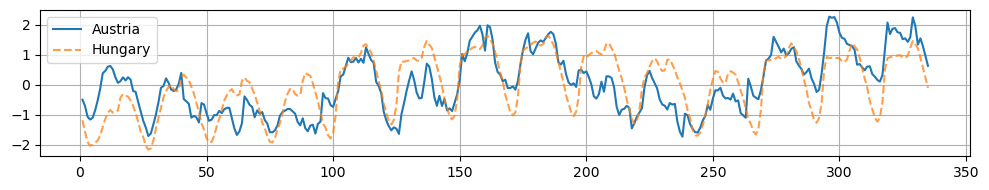

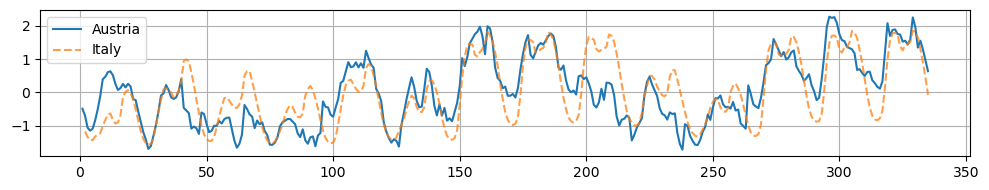

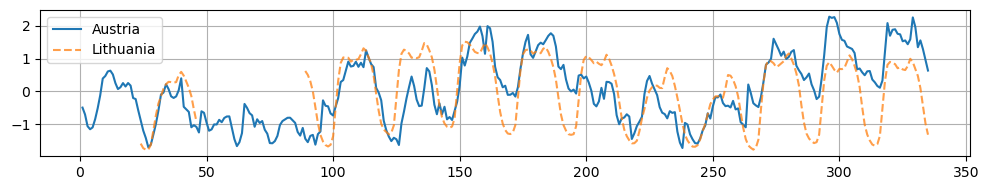

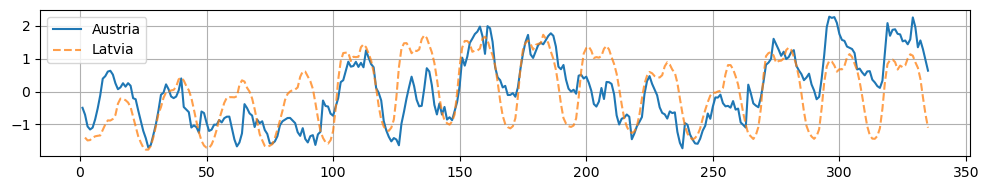

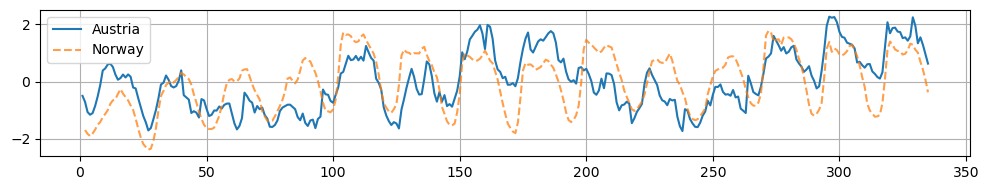

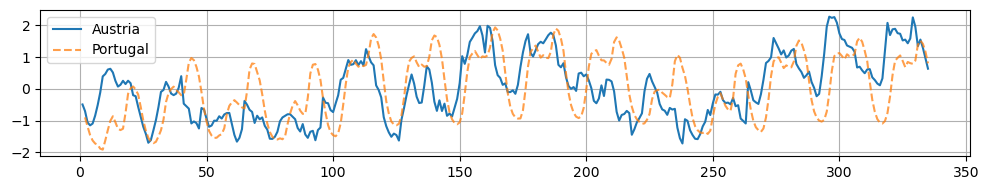

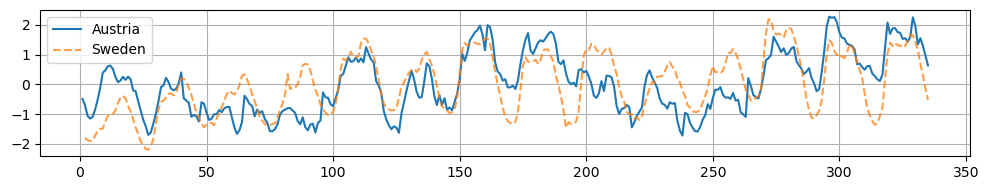

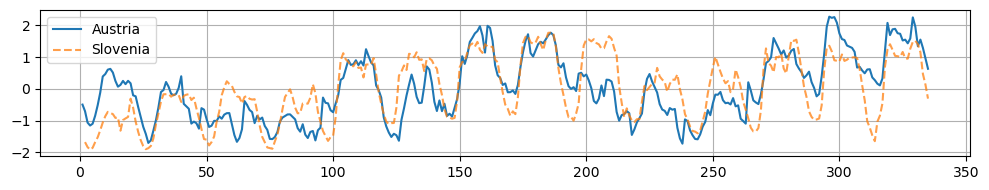

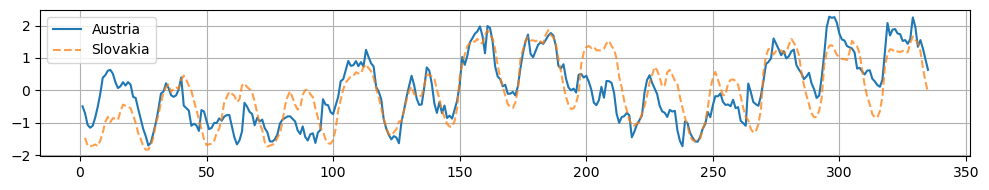

In [58]:
# for i in range(len(lab)):
#     fig = plt.figure(figsize=(10,2))
#     if i > 0:
#         plt.plot(zscore(dataset['AT_load_actual_entsoe_transparency'][:24*14],nan_policy="omit"),label="Austria")
#         plt.plot(zscore(dataset[lab[i]][:24*14],nan_policy="omit"),label=l[i],alpha=0.75,linestyle='dashed')
#         plt.legend()
#         plt.grid()

# plt.show()

# Random Day, Not Obvious Holiday

In [6]:
## Random day that is not an obvious holiday in any of the countries of interest
e_PRECIS = Experiment("PHASEINV", [4,24*2], algyield=True, multivariate=False, downsamplefactor=1)
find = dataset['utc_timestamp']
print(find[19009], find[31129], find[45001], find[50017])
DAY1 = 20001 # needed to find days that were not holidays in any of the countries
DAY2 = 31129
DAY3 = 45001
DAY4 = 50001-8
a = np.array(dataset['utc_timestamp'])
lens = []
print("Timestamps: {}, {}".format(a[0],a[-1]))
rand_dicts = []
label_colors = {k:'k' for k in l}
for lk_idx in tqdm(range(len(lab))):
    lk = lab[lk_idx]
    dat = zscore(dataset[lk],nan_policy='omit')
    lens.append(len(dat))
    d = [dat[DAY1:DAY1+48], dat[DAY2:DAY2+48], dat[DAY3:DAY3+48], dat[DAY4:DAY4+48]]
    idxs = [(DAY1,DAY1+48), (DAY2,DAY2+48), (DAY3,DAY3+48), (DAY4,DAY4+48)]
    rand_dicts.append(np.array(d))


100%|██████████| 18/18 [00:00<00:00, 332.30it/s]

2017-03-03T00:00:00Z 2018-07-21T00:00:00Z 2020-02-19T00:00:00Z 2020-09-15T00:00:00Z
Timestamps: 2014-12-31T23:00:00Z, 2020-09-30T23:00:00Z


Make Distmat: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


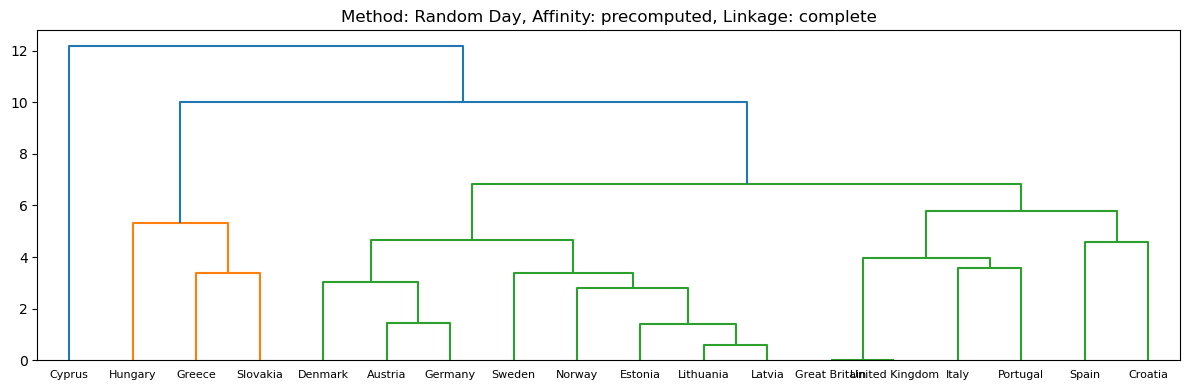

(50401, 18)


In [7]:
RANDOMDAYPRECISdistmat = e_PRECIS.distmat_from_dicts(rand_dicts)
plotty_ac(None, "Random Day",'precomputed', 'complete', RANDOMDAYPRECISdistmat, l, label_colors)

values,counts = np.unique(lens,return_counts=True)
for i in zip(values,counts):
    print(i)

# k-Shape

In [11]:
## kShape
a = np.array(dataset['utc_timestamp'])
print("Timestamps: {}, {}".format(a[0],a[-1]))
clusterts = []
numts = 0
label_colors = {k:'k' for k in l}
for lk_idx in range(len(lab)):
    lk = lab[lk_idx]
    dat = zscore(dataset[lk],nan_policy='omit')
    bad = np.where(np.isnan(dat))
    dat[bad[0]] = np.nanmean(dat) # in this particular example, only one datapoint is nan
    clusterts.append(dat)
    numts += 1
STARTTIME = time.time()
clusters = kshape(clusterts, 5) # NO GROUND TRUTH FOR HOW MANY CLUSTERS THERE SHOULD BE
ENDTIME = time.time()
print("kShape Time Elapsed: {}".format(ENDTIME-STARTTIME))
c = [i[1] for i in clusters] # index 0 are the values
for j in c: # print clusters
    print(np.asarray(l)[j])

Timestamps: 2014-12-31T23:00:00Z, 2020-09-30T23:00:00Z


: 

: 

# Catch-22

Compute C22 Feature Vectors: 100%|██████████| 18/18 [00:27<00:00,  1.55s/it]


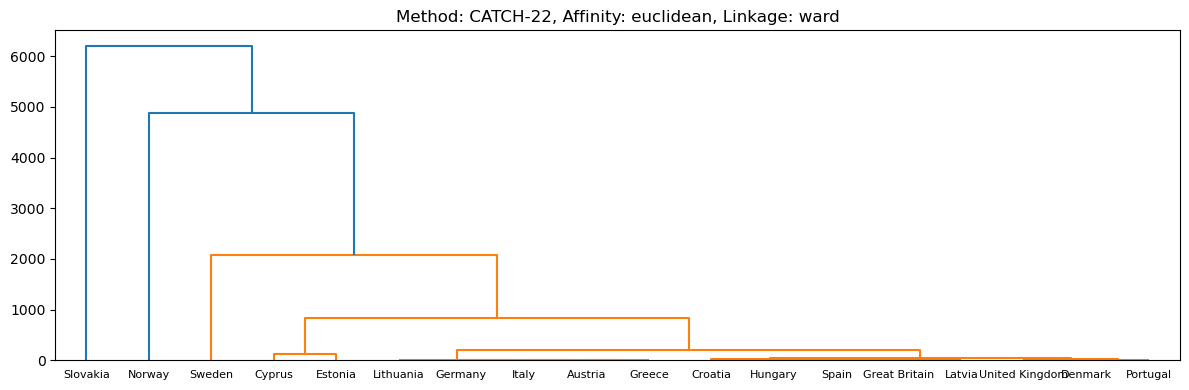

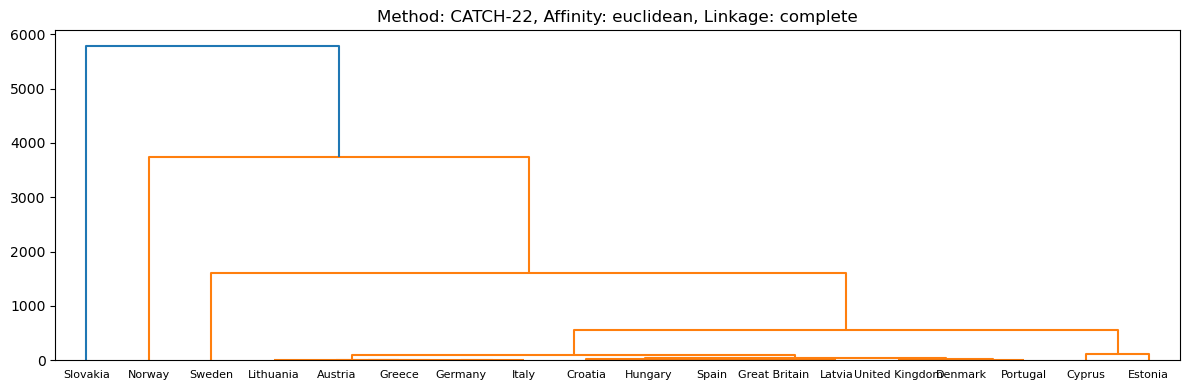

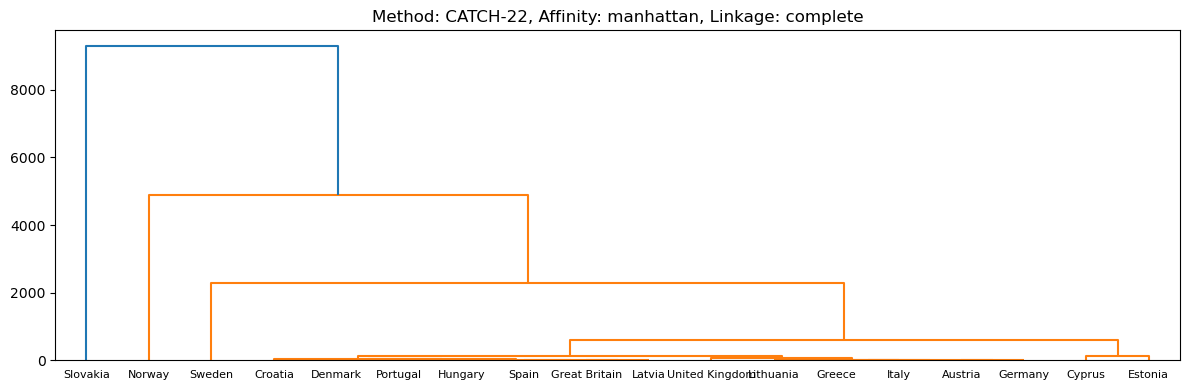

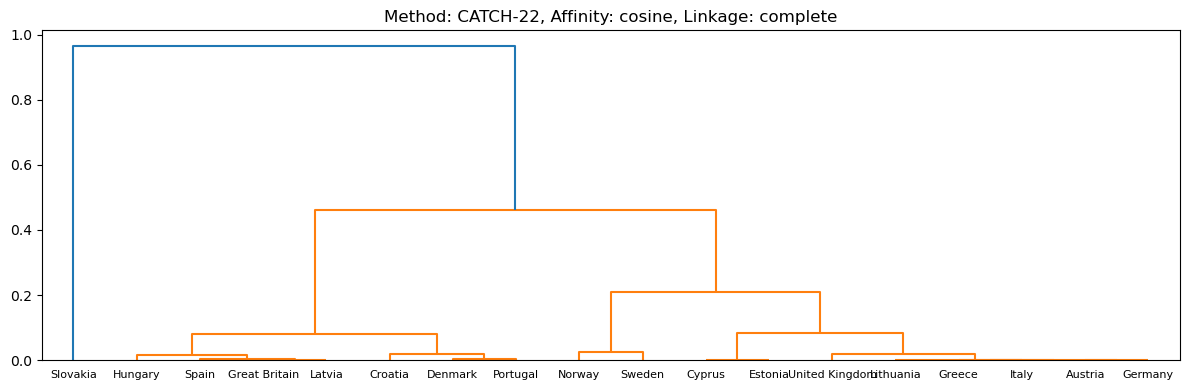

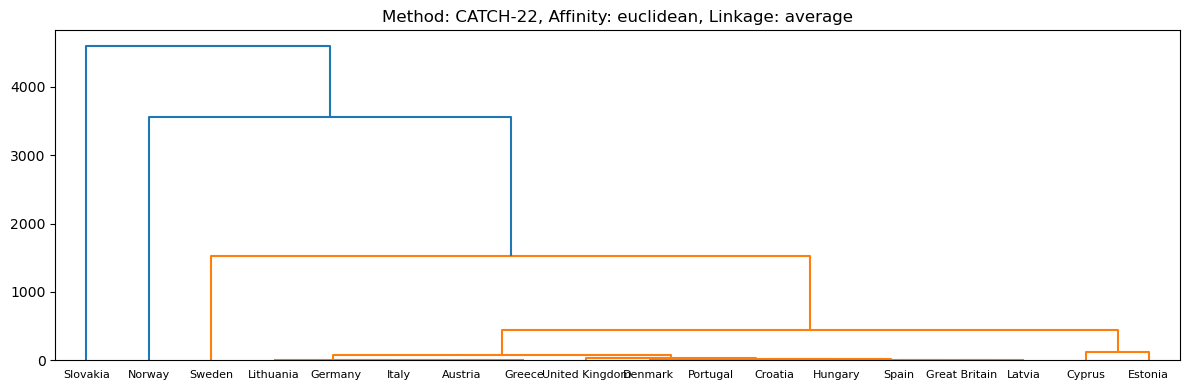

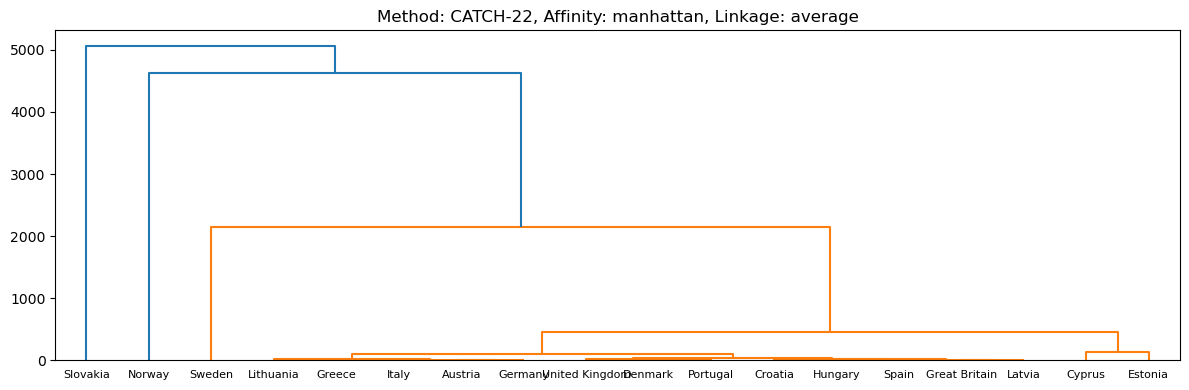

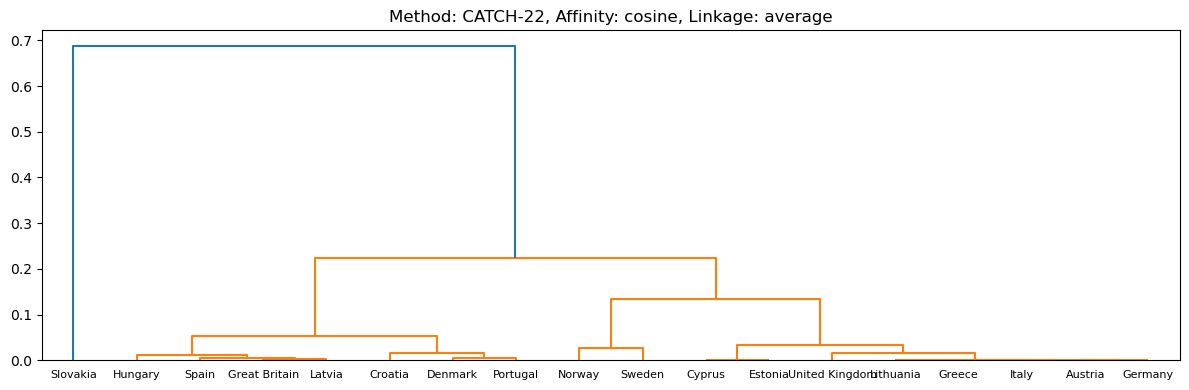

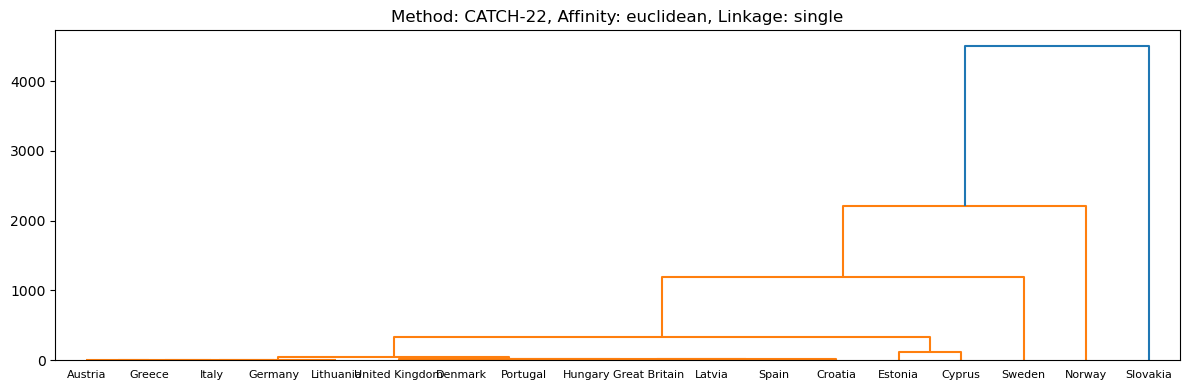

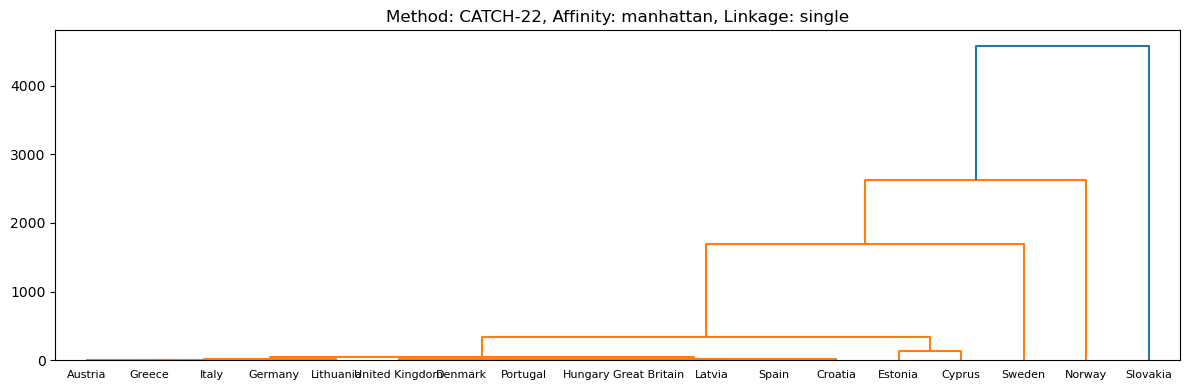

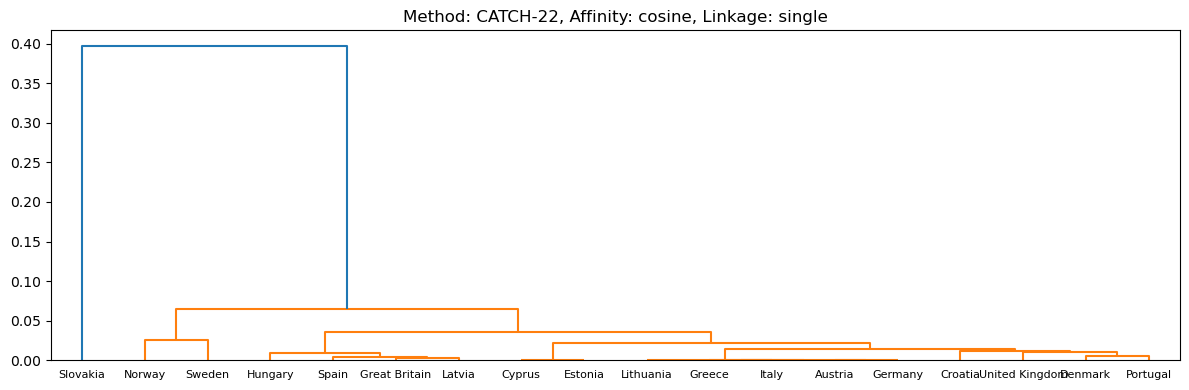

In [5]:
import catch22 # znorm internally

observationvectors = []
for lk_idx in tqdm(range(len(lab)),desc="Compute C22 Feature Vectors"):
    lk = lab[lk_idx]
    ts = dataset[lk]
    good = ~np.isnan(ts)
    bad = np.isnan(ts)
    avg = np.mean(ts[good])
    ts[bad] = avg
    ts = zscore(ts,nan_policy='omit')
    fV = catch22.catch22_all(ts)
    fV_values = np.array(fV['values'])
    observationvectors.append(fV_values)

rootsavename = "<save figures to this directory>"
linkagetypes = ['ward','complete', 'average', 'single']
affinities = ['euclidean','manhattan', 'cosine']
for linkage in linkagetypes:
    for affinity in affinities:
        if linkage == 'ward':
            # plotty_ac(rootsavename+"euclidean{}.svg".format(linkage), "CATCH-22", "euclidean", linkage, observationvectors, l, label_colors)
            plotty_ac(None, "CATCH-22", "euclidean", linkage, observationvectors, l, label_colors)
            break
        else:
            # plotty_ac(rootsavename+"{}{}.svg".format(affinity,linkage), "CATCH-22",affinity,linkage,observationvectors,l,label_colors)
            plotty_ac(None, "CATCH-22", affinity, linkage, observationvectors, l, label_colors)
